<h1>REINFORCEMENT LEARNING (PENDULUM)<h1\>

### Description 

The inverted pendulum swingup problem is based on the classic problem in control theory. The system consists of a pendulum attached at one end to a fixed point, and the other end being free. The pendulum starts in a random position and the goal is to apply torque on the free end to swing it into an upright position, with its center of gravity right above the fixed point. 

The diagram below specifies the coordinate system used for the implementation of the pendulum's dynamic equations. 


-  `x-y`: cartesian coordinates of the pendulum's end in meters. 
- `theta` : angle in radians. 
- `tau`: torque in `N m`. Defined as positive _counter-clockwise_. 

### Action Space 

The action is a `ndarray` with shape `(1,)` representing the torque applied to free end of the pendulum. 

| Num | Action | Min  | Max | 
|-----|--------|------|-----| 
| 0   | Torque | -2.0 | 2.0 | 

### Observation 

Space The observation is a `ndarray` with shape `(3,)` representing the x-y coordinates of the pendulum's free end and its angular velocity. 
| Num | Observation      | Min  | Max | 
|-----|------------------|------|-----| 
| 0   | x = cos(theta)   | -1.0 | 1.0 | 
| 1   | y = sin(theta)   | -1.0 | 1.0 | 
| 2   | Angular Velocity | -8.0 | 8.0 | 

### Rewards 

The reward function is defined as: 
*r = -(theta<sup>2</sup> + 0.1 * theta_dt<sup>2</sup> + 0.001 * torque<sup>2</sup>)* 
where `$\theta$` is the pendulum's angle normalized between *[-pi, pi]* (with 0 being in the upright position). 

Based on the above equation, the minimum reward that can be obtained is *-(pi<sup>2</sup> + 0.1 * 8<sup>2</sup> + 0.001 * 2<sup>2</sup>) = -16.2736044*, while the maximum reward is zero (pendulum is upright with zero velocity and no torque applied). 

### Starting 

State The starting state is a random angle in *[-pi, pi]* and a random angular velocity in *[-1,1]*. 

### Episode 

Truncation The episode truncates at 200 time steps. ### Arguments - `g`: acceleration of gravity measured in *(m s<sup>-2</sup>)* used to calculate the pendulum dynamics. The default value is g = 10.0 . ``` gym.make('Pendulum-v0', g=9.81) ```

https://ieeexplore.ieee.org/document/8853619

https://karpathy.github.io/2016/05/31/rl/



In [1]:
import gym
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
from collections import deque
import argparse
import pickle
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
import os
import random

### Testing Environment

The code below simulates how an agent interacts with the pendulum environment. For each "episode", a simple loop is used to simulate an agent doing random actions in the environment. Since there is no model to make the agent learn to balance the stick vertically, the score will be very low ( <0 )

In [2]:
env = gym.make('Pendulum-v0')

episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    
    while not done:
        action = [random.uniform(-2, 2)]
        observation, reward, done, info = env.step(action)
        score += reward
        env.render()
        
    print(f"Episode {episode}, Score: {score}") 
    
env.close()

Episode 1, Score: -1466.4649659616473


## Single DQN Agent

 The DQN (Deep Q-Network) algorithm was developed by DeepMind in 2015. It was able to solve a wide range of Atari games (some to superhuman level) by combining reinforcement learning and deep neural networks at scale. The algorithm was developed by enhancing a classic RL algorithm called Q-Learning with deep neural networks and a technique called experience replay.


 ### Epsilon-Greedy Action Selection Policy

In this model, we will be using the epsilon-greedy action selection to determine the exploration and exploitation tradeoff. In epsilon-greedy action selection, the agent uses both exploitations to take advantage of prior knowledge and exploration to look for new options. The epsilon-greedy approach selects the action with the highest estimated reward most of the time. The aim is to have a balance between exploration and exploitation. Exploration allows us to have some room for trying new things, sometimes contradicting what we have already learned. Exploration allows us to have some room for trying new things, sometimes contradicting what we have already learned.

The epsilon parameter introduces randomness into the algorithm, forcing the model to try different actions. This helps not getting stuck in a local optimum. If epsilon is set to 0, we never explore but always exploit the knowledge we already have. On the contrary, having the epsilon set to 1 force the algorithm to always take random actions and never use past knowledge. Usually, epsilon is selected as a small number close to 0. In our case, we set the epsilon to 0.1.


References:

- [Epsilon-Greedy Q-Learning](https://www.baeldung.com/cs/epsilon-greedy-q-learning#:~:text=In%20epsilon%2Dgreedy%20action%20selection,balance%20between%20exploration%20and%20exploitation.)

2024-02-01 15:26:07.694785: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-02-01 15:26:07.694859: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-01 15:26:07.694878: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-01 15:26:07.694974: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-01 15:26:07.695027: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Episode: 1, Total Reward: -1098.57, Epsilon: 0.03
Best model weights saved.
Episode: 2, Total Reward: -1572.19, Epsilon: 0.01
Episode: 3, Total Reward: -1654.01, Epsilon: 0.01
Episode: 4, Total Reward: -1111.57, Epsilon: 0.01
Episode: 5, Total Reward: -950.08, Epsilon: 0.01
Best model weights saved.
Episode: 6, Total Reward: -1088.05, Epsilon: 0.01
Episode: 7, Total Reward: -818.57, Epsilon: 0.01
Best model weights saved.
Episode: 8, Total Reward: -261.43, Epsilon: 0.01
Best model weights saved.
Episode: 9, Total Reward: -639.84, Epsilon: 0.01
Episode: 10, Total Reward: -125.06, Epsilon: 0.01
Best model weights saved.
Episode: 11, Total Reward: -123.18, Epsilon: 0.01
Best model weights saved.
Episode: 12, Total Reward: -114.81, Epsilon: 0.01
Best model weights saved.
Episode: 13, Total Reward: -119.09, Epsilon: 0.01
Episode: 14, Total Reward: -123.87, Epsilon: 0.01
Episode: 15, Total Reward: -243.41, Epsilon: 0.01
Episode: 16, Total Reward: -126.40, Epsilon: 0.01
Episode: 17, Total Rew

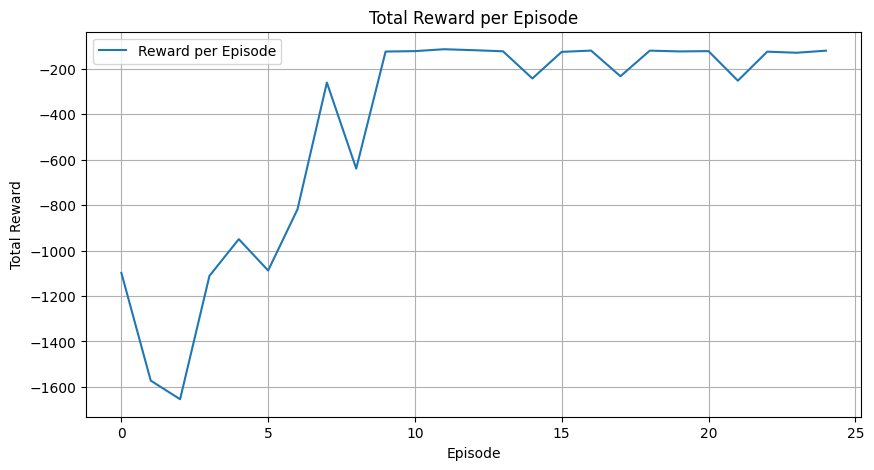

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import deque
import gym
import os
import random
import warnings

# To ignore all warnings
warnings.filterwarnings("ignore")

'''
This class stores experience transoitions encountered by the agent during training. This mechanism
is a core component of experience replay technique used in DQN networks to stablize and improve the learning process.
We are using a deque to store the transitions. 
'''
class Memory:
    # Constructor, the capacity is the maximum size of the memory. Once capacity is reached, the old memories are removed.  
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
    
    '''
    Adds transition to the memory. The transition is a tuple of (state, action, reward, next_state).
    If the maximum capacity of memory is reached, the old memories are overrided.
    '''
    def update(self, transition):
        self.memory.append(transition)
    
    '''
    Retrieve a random sample from memory, batch size indicates the number of samples to be retrieved.
    '''
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)


'''
Model architecture for the DQN network. The model takes the state as input and outputs the Q values for each action.
'''
class Net(tf.keras.Model):
    # constructor initializes the layers
    def __init__(self, input_size, num_actions):
        super(Net, self).__init__()
        self.dense1 = Dense(128, activation='relu', input_shape=(input_size,))
        self.dense2 = Dense(128, activation='relu')
        self.output_layer = Dense(num_actions, activation='linear')
    
    '''
    This function is the forward pass of the model. It takes the state as input and returns the Q values for each action.
    'x' is the input to the model, which is the state from the environment. 'x' is then passed through the 2 dense
    layers and the output layer to get the predicted values for each action. We use a linear activation function 'relu' to
    predict a wide range of values, to estimate action values in the RL model
    '''
    def call(self, x):
        # first dense layer
        x = self.dense1(x)
        # second dense layer
        x = self.dense2(x)
        return self.output_layer(x)


'''
This Agent class performs the behaviour and learning algorithm of the DQN model (agent). This class has the methods
for action selection, memory storage, parameter saving, and the learning algorithm of the dueling DQN network. 
'''
class Agent:
    # this constructor initializes the environment, model, memory, and other variables required for the agent
    def __init__(self, env_string, num_actions, state_size, batch_size=32, learning_rate=0.01, gamma=0.98, epsilon=1.0, epsilon_decay=0.98, epsilon_min=0.01, tau=0.01, memory_capacity=10000):
        self.env_string = env_string
        self.env = gym.make(env_string)
        self.env.reset()
        
        self.state_size = state_size
        self.num_actions = num_actions
        self.action_scope = [i * 4.0 / (num_actions - 1) - 2.0 for i in range(num_actions)] # Adjusted to match action scaling in dueling DQN
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.tau = tau
        self.memory = Memory(memory_capacity)
        self.best_total_reward = float('-inf')
        
        self.model = Net(state_size, num_actions)
        self.target_model = Net(state_size, num_actions)
        self.optimizer = Adam(learning_rate)
        self.loss_fn = tf.losses.MeanSquaredError()

    '''
    Implements the epsilon-greedy policy. With probability epsilon, a random action is selected, otherwise the action chosen will
    be the one with the highest Q value. The epsilon value is decayed over time to reduce the exploration as the agent learns.
    It also converts the state to a tensor before passing through to the model.
    '''
    def select_action(self, state):
        # if random number is less than epsilon, return random action 
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions), None
        # convert to tensor
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        q_values = self.model(state)
        # else, return action with highest Q value
        return np.argmax(q_values.numpy()), None

    # Store experience tuple into the memory buffer, function is above
    def store_transition(self, state, action, reward, next_state):
        self.memory.update((state, action, reward, next_state, False))

    '''
    Learn function performs single step training on a batch of experiences sampled from the memory buffer.
    '''
    def learn(self):
        if len(self.memory.memory) < self.batch_size:
            return

        # sample a batch of transitions from the memory
        transitions = self.memory.sample(self.batch_size)
        # extract the states, actions, rewards, next states, from the batch
        state_batch, action_batch, reward_batch, next_state_batch, _ = zip(*transitions)
        
        # convert the s, a, r, s_' to tensors
        state_batch = tf.convert_to_tensor(state_batch, dtype=tf.float32)
        action_batch = tf.convert_to_tensor(action_batch, dtype=tf.int32)
        reward_batch = tf.convert_to_tensor(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(next_state_batch, dtype=tf.float32)

        '''
        Tensorflow GradientTape is an API for automatic differentiation. It records operations for automatic differentiation.
        This function will calculate the predicted Q-values from the current state and actions.
        '''
        with tf.GradientTape() as tape:
            '''
            Forward pass through the DQN model to get the Q-values for all actions given the current batch of states.
            q-values contains the predicted q-values for each action in each state of the batch
            '''
            q_values = self.model(state_batch)
            
            '''
            'action_indices' calculates the indices of the actions taken in the Q-value matrix. 
            Since q_values contains Q-values for all actions, this step is necessary to select only the Q-values corresponding to the actions that were actually taken.
            '''
            action_indices = tf.range(self.batch_size) * self.num_actions + action_batch
            
            '''
            Reshapes the Q-value matrix to a single vector, then selects the Q-values for the actions taken using the 'action_indices' calculated above.
            '''
            predicted_q = tf.gather(tf.reshape(q_values, [-1]), action_indices)
            
            '''
            Forward pass through the target DQN model to get Q-values for all actions given the next states. 
            '''
            next_q_values = self.target_model(next_state_batch)
            
            # Finds the maximum Q-value among all actions for each next state, which represents the best possible future reward achievable from the next state.
            max_next_q = tf.reduce_max(next_q_values, axis=1)
            
            '''
            Calculates the target Q-values using the immediate reward received (reward_batch) and the 
            discounted maximum future reward (self.gamma * max_next_q). This forms the update target for the Q-value of the action taken.
            '''
            target_q = reward_batch + self.gamma * max_next_q
            
            # Calculates the loss between the predicted Q-values and the target Q-values, basically MSE loss
            loss = self.loss_fn(target_q, predicted_q)
        
        # Calculate the gradients of the loss with respect to the model parameters
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        
        self.update_epsilon()

    # update the epsilon value
    def update_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon_decay * self.epsilon)
    
    # update the model
    def update_target_model(self):
        main_weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = self.tau * main_weights[i] + (1 - self.tau) * target_weights[i]
        self.target_model.set_weights(target_weights)

    # checks if current model is the best model based on total reward
    def is_best_model(self, total_reward):
        return total_reward > self.best_total_reward

    # updates the best model with the current model
    def update_best_model(self, total_reward):
        self.best_total_reward = total_reward

def plot_rewards(rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label='Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode')
    plt.legend()
    plt.grid(True)
    plt.show()

def save_model_weights(agent, model_dir):
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    weights_path = os.path.join(model_dir, 'tensorflow_dqn_weights.h5')
    agent.model.save_weights(weights_path)

# Main function to run the training
def main():
    env_string = 'Pendulum-v0'
    num_actions = 5
    state_size = gym.make(env_string).observation_space.shape[0]
    agent = Agent(env_string, num_actions, state_size)

    episodes = 25
    rewards = []  # Initialize rewards list to store total rewards per episode
    for ep in range(episodes):
        state = agent.env.reset()
        done = False
        total_reward = 0
        while not done:
            action_index, _ = agent.select_action(state)
            action = [agent.action_scope[action_index]] 
            next_state, reward, done, _ = agent.env.step(action)
            agent.store_transition(state, action_index, reward, next_state)
            state = next_state
            total_reward += reward
            
            agent.learn()
            agent.update_target_model()

        rewards.append(total_reward)  # Append the total reward of the episode to the rewards list
        
        print(f"Episode: {ep+1}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")

        if agent.is_best_model(total_reward):
            # Update and save the best model weights
            agent.update_best_model(total_reward)
            model_dir = 'param'
            save_model_weights(agent, model_dir)
            print("Best model weights saved.")
    
    plot_rewards(rewards)  # Plot the rewards after completing all episodes


main()


In [3]:
import numpy as np
import tensorflow as tf
import gym
import os

class Net(tf.keras.Model):
    def __init__(self, input_size, num_actions):
        super(Net, self).__init__()
        self.dense1 = tf.keras.layers.Dense(128, activation='relu', input_shape=(input_size,))
        self.dense2 = tf.keras.layers.Dense(128, activation='relu')
        self.output_layer = tf.keras.layers.Dense(num_actions, activation='linear')
    
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.output_layer(x)

def load_model(model_path, input_size, num_actions):
    model = Net(input_size, num_actions)
    # Create a dummy input and call the model to initialize variables
    dummy_input = tf.zeros((1, input_size))
    model(dummy_input)
    # Now load the weights
    model.load_weights(model_path)
    return model


def test_model(env_string, model, num_episodes=5):
    env = gym.make(env_string)
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            state = tf.convert_to_tensor([state], dtype=tf.float32)
            action_values = model(state)
            action = np.argmax(action_values.numpy()[0])
            # Convert discrete action to continuous action for Pendulum
            action = [action * 4.0 / (model.output_layer.units - 1) - 2.0]
            next_state, reward, done, _ = env.step(action)
            env.render()  # Comment this out if running in a non-graphical environment
            state = next_state
            total_reward += reward
        print(f"Episode: {episode+1}, Total Reward: {total_reward:.2f}")
    
    env.close()

if __name__ == '__main__':
    env_string = 'Pendulum-v0'
    input_size = gym.make(env_string).observation_space.shape[0]
    num_actions = 5  # Must match the number used during training
    
    model_dir = 'param'
    weights_path = os.path.join(model_dir, 'tensorflow_dqn_weights.h5')
    
    # Ensure the model path exists
    if os.path.exists(weights_path):
        model = load_model(weights_path, input_size, num_actions)
        test_model(env_string, model)
    else:
        print(f"Model weights not found in {weights_path}. Please ensure the correct path.")


Episode: 1, Total Reward: -1.08
Episode: 2, Total Reward: -252.69
Episode: 3, Total Reward: -128.33
Episode: 4, Total Reward: -120.85
Episode: 5, Total Reward: -1.75


AttributeError: 'CocoaAlternateEventLoop' object has no attribute 'platform_event_loop'

: 

### Dueling DQN (Pytorch implementation)

For our DQN Model, we will be using the Pytorch module first since it is easier to implement and runs faster, before moving onto Tensorflow. 

A Dueling Network is a type of Q-Network that has two streams to separately estimate (scalar) state-value and the advantages for each action. Both streams share a common convolutional feature learning module. The two streams are combined via a special aggregating layer to produce an estimate of the state-action value function Q as shown in the figure to the right.


References:

- [Dueling Network Architectures for Deep Reinforcement Learning](https://arxiv.org/abs/1511.06581v3)

![img](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-03_at_3.24.01_PM.png 'Nil')

Ep 0	Average score: -1066.74	Average Q: 0.00
Ep 10	Average score: -1273.12	Average Q: 0.37
Ep 20	Average score: -1134.14	Average Q: 2.64
Ep 30	Average score: -680.52	Average Q: 6.33
Ep 40	Average score: -451.42	Average Q: 7.89
Ep 50	Average score: -309.87	Average Q: 8.72
Ep 60	Average score: -357.59	Average Q: 7.92
Ep 70	Average score: -232.90	Average Q: 9.23
Solved! Running reward is now -193.9380952046245!


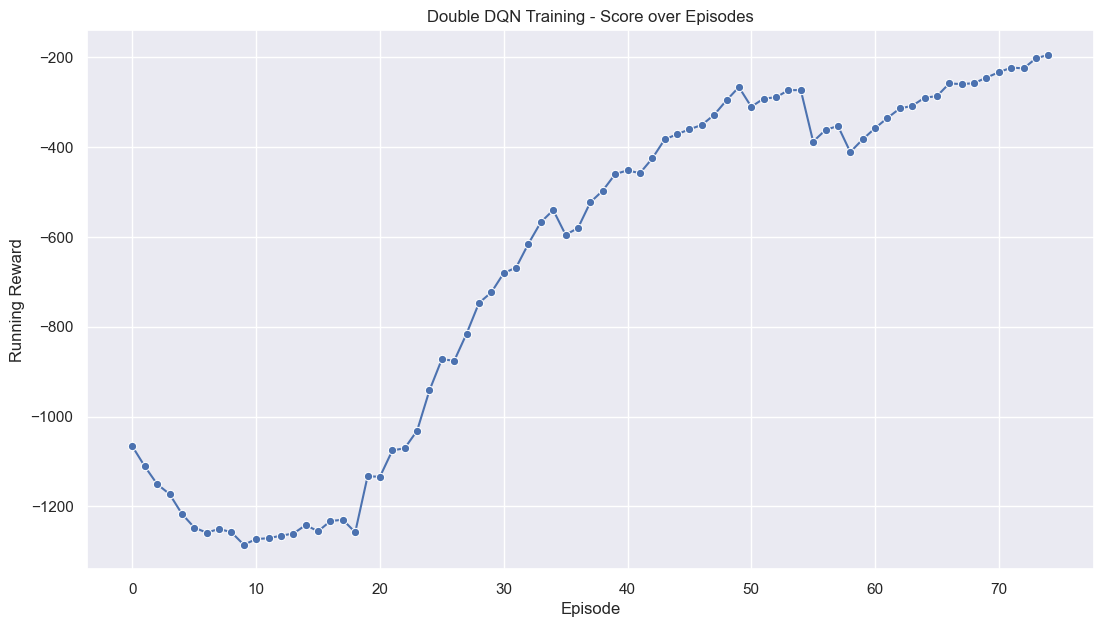

In [31]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Hyperparameters for DQN algorithm
class Args:
    gamma = 0.9 # discount factor
    num_actions = 5
    seed = 0
    render = False
    log_interval = 10

args = Args()

torch.manual_seed(args.seed)
np.random.seed(args.seed)

# Store the training records (episode number and reward)
TrainingRecord = namedtuple('TrainingRecord', ['ep', 'reward'])
# Store the transitions -> state (s), action (a), reward (r). next state (s_)
Transition = namedtuple('Transition', ['s', 'a', 'r', 's_'])

# Defines the neural network used by the DQN agent. Dense model with a linear activation function
class Net(nn.Module):

    def __init__(self):
        # initialize the base c;ass for pytorch
        super(Net, self).__init__()
        '''
        dense fully connected layer with input size of 3 and output size of 100. Initial feature extractor from the 
        input state vector, in this case (Pendulum-v0) represents the continuous state space. 
        '''
        self.fc = nn.Linear(3, 100)
        '''
        This layer maps the 100 dimension feature representation to a space representing the action values (Q-values) for
        each possible action
        '''
        self.a_head = nn.Linear(100, args.num_actions)
        '''
        Another layer that also maps the 100 dimension feature representation to a single value (V). This is part of the dueling DQN 
        architecture concept, where the network separately estimates state values and advantage values.
        '''
        self.v_head = nn.Linear(100, 1)

    # Forward pass combines state and action values to produce Q-values for Dueling DQN. 
    def forward(self, x):
        # Using the tanh activation function 
        x = F.tanh(self.fc(x))
        a = self.a_head(x) - self.a_head(x).mean(1, keepdim=True)
        v = self.v_head(x)
        # Computes state value (V) with advantage value (a) for each action to produce final Q-values.
        action_scores = a + v
        return action_scores


'''
This class stores experience transoitions encountered by the agent during training. This mechanism
is a core component of experience replay technique used in DQN networks to stablize and improve the learning process.
'''
class Memory():
    data_pointer = 0 # keeps track of current index in the memory buffer where the next transition will be stored.
    isfull = False # flag indicating whether memory buffer has been filled up at least once. Important to know whether memory buffer contains enough samples to start sampling or not

    # initialize the memory buffer
    def __init__(self, capacity):
        self.memory = np.empty(capacity, dtype=object)
        self.capacity = capacity

    # method to add a new transition to the memory buffer
    def update(self, transition):
        # new transition is stored in the memory at the data pointer index, which was initialized above, starting from 0
        self.memory[self.data_pointer] = transition
        # increment the data pointer to next location in memory for the next transition
        self.data_pointer += 1
        # if the buffer is filled, the flag will indicate TRUE and the future updates will start overwriting the old transitions, as pointer will reset to 0
        if self.data_pointer == self.capacity:
            self.data_pointer = 0
            self.isfull = True

    # this method randomly samples a batch of transitions from the memory, and batch_size determines the size of the batch.
    def sample(self, batch_size):
        return np.random.choice(self.memory, batch_size)

'''
This Agent class performs the behaviour and learning algorithm of the DQN model (agent). This class has the methods
for action selection, memory storage, parameter saving, and the learning algorithm of the dueling DQN network. It initializes
the 2 neural networks (eval_net and target_net) for calculating the Q-values, and an optimizer for training the eval_net.
'''
class Agent():

    '''
    This action_list generates a list of actions the agent can take. Since a DQN model is meant for discrete action spaces, but the Pendulum-v0 is 
    a continuous action space, we will need to convert the action space to discrete. We can do that by pre-defining the actions the model can take, such 
    as an increment of values from -2 to 2. This allows the model to choose a specific number. 
    '''
    action_list = [(i * 4 - 2,) for i in range(args.num_actions)]
    max_grad_norm = 0.5

    def __init__(self):
        self.training_step = 0
        # initial exploration rate is 1, which decays over time to encourage exploration at the start and exploitation of the learned policy later.
        self.epsilon = 1
        # the models
        self.eval_net, self.target_net = Net().float(), Net().float()
        # memory
        self.memory = Memory(2000)
        # optimizer
        self.optimizer = optim.Adam(self.eval_net.parameters(), lr=1e-3)

    '''
    The select action method, uses the epsilon-greedy polict for action selection. With the probability of epsilon (e), it
    selects a random action (exploration), and when the probability 1 - epsilon, it selects the action with the highest Q-value as predicted by the eval_net (exploitation).
    '''
    def select_action(self, state):
        # Convert state from numpy array to pytorch tensor and process it to get action values
        state = torch.from_numpy(state).float().unsqueeze(0)
        if np.random.random() < self.epsilon:
            action_index = np.random.randint(args.num_actions)
        else:
            # Updates policy network using gradiens from loss between predicted and target Q-values
            probs = self.eval_net(state)
            action_index = probs.max(1)[1].item()
        return self.action_list[action_index], action_index

    # save parameters
    def save_param(self):
        if not os.path.exists('param'):
            os.makedirs('param')
        torch.save(self.eval_net.state_dict(), 'param/dqn_net_params.pkl')

    # store transition in the memory buffer. Contains the s, a, r ,s_ for the model to learn
    def store_transition(self, transition):
        self.memory.update(transition)

    '''
    This update method performs a single update step on the eval_net model, using a random batch of transitions from the memory. This
    method will 
    1. Sample a batch and convert them to pytorch tensors
    2. Use a double dqn method to decouple selection and evaluation of actions, 
    which will help reduce overestimations of Q-values regularly seen in natural DQNs
    3. Calculate the loss between predicted and target Q-values, and we use a smoothing L1 regularization
    technique as the loss objective function
    4. Perform backpropagation and optimization to update weights of eval_net
    5. Update target_net every 200 steps
    6. Decay exploration rate (epsilon) to slowly shift from exploration to exploitation
    '''
    def update(self):
        self.training_step += 1
        
        # take a batch from memory
        transitions = self.memory.sample(32)
        s = torch.tensor([t.s for t in transitions], dtype=torch.float)
        a = torch.tensor([t.a for t in transitions], dtype=torch.long).view(-1, 1)
        r = torch.tensor([t.r for t in transitions], dtype=torch.float).view(-1, 1)
        s_ = torch.tensor([t.s_ for t in transitions], dtype=torch.float)

        # natural dqn
        # q_eval = self.eval_net(s).gather(1, a)
        # with torch.no_grad():
        #     q_target = r + args.gamma * self.target_net(s_).max(1, keepdim=True)[0]

        # double dqn method, to reduce overestimations of Q-values
        with torch.no_grad():
            a_ = self.eval_net(s_).max(1, keepdim=True)[1]
            q_target = r + args.gamma * self.target_net(s_).gather(1, a_)
        q_eval = self.eval_net(s).gather(1, a)

        # optimizer 
        self.optimizer.zero_grad()
        # loss smoothing using l1 regularization, and calculating the loss between predicted and target q-values
        loss = F.smooth_l1_loss(q_eval, q_target)
        loss.backward()
        nn.utils.clip_grad_norm_(self.eval_net.parameters(), self.max_grad_norm)
        self.optimizer.step()

        # update the target_net every 200 steps to synchronise model with eval_net
        if self.training_step % 200 == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())

        # epsilon decay rate to move from exploration to exploitation
        self.epsilon = max(self.epsilon * 0.999, 0.01)

        return q_eval.mean().item()

# Main function to call all our above functions for the model to run
def main():
    env = gym.make('Pendulum-v0')
    env.seed(args.seed)

    agent = Agent()

    episodes, rewards = [], []  # Initialize empty lists to store episodes and rewards
    running_reward, running_q = -1000, 0
    for i_ep in range(100):
        score = 0
        state = env.reset()

        for t in range(200):
            action, action_index = agent.select_action(state)
            state_, reward, done, _ = env.step(action)
            score += reward
            if args.render:
                env.render()
            agent.store_transition(Transition(state, action_index, (reward + 8) / 8, state_))
            state = state_
            if agent.memory.isfull:
                q = agent.update()
                running_q = 0.99 * running_q + 0.01 * q

        running_reward = running_reward * 0.9 + score * 0.1

        episodes.append(i_ep)
        rewards.append(running_reward)

        if i_ep % args.log_interval == 0:
            print('Ep {}\tAverage score: {:.2f}\tAverage Q: {:.2f}'.format(i_ep, running_reward, running_q))
        if running_reward > -200:
            print("Solved! Running reward is now {}!".format(running_reward))
            agent.save_param()
            break

    env.close()
    
    return episodes, rewards  # Return the collected episodes and rewards

# Ensure this line is at the end of the script to call main and collect data
episodes, rewards = main()

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Set the seaborn style for the plots
sns.set_theme(style="darkgrid")

# Create the plot
plt.figure(figsize=(13, 7))
sns.lineplot(x=episodes, y=rewards, marker='o', linestyle='-', color='b')

# Set the title and labels
plt.title('Double DQN Training - Score over Episodes')
plt.xlabel('Episode')
plt.ylabel('Running Reward')

# Show the plot
plt.show()

### Testing the dueling DQN model

In [32]:
import torch
import gym
import numpy as np

class Args:
    num_actions = 5  # Update this if necessary

args = Args()

model = Net()
model.load_state_dict(torch.load('param/dqn_net_params.pkl'))
model.eval()  # Set the model to evaluation mode

def test_model(env_name='Pendulum-v0', num_episodes=10, render=True):
    env = gym.make(env_name)
    env.seed(123)  # Optionally set a seed for reproducibility
    total_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        
        while True:
            state_tensor = torch.from_numpy(state).float().unsqueeze(0)
            with torch.no_grad():
                action_index = model(state_tensor).max(1)[1].view(1, 1)
            # Convert the action index to the actual action using your mapping
            action = [(action_index.item() * 4 / (args.num_actions - 1)) - 2]  # Adjust this based on your action mapping

            next_state, reward, done, _ = env.step(action)
            episode_reward += reward

            if render:
                env.render()

            if done:
                print(f"Episode: {episode + 1}, Total Reward: {episode_reward:.2f}")
                total_rewards.append(episode_reward)
                break
            
            state = next_state

    env.close()
    print(f"Average Reward: {np.mean(total_rewards):.2f}")

test_model(num_episodes=5,render=True)


Episode: 1, Total Reward: -127.44
Episode: 2, Total Reward: -123.43
Episode: 3, Total Reward: -597.23
Episode: 4, Total Reward: -680.03
Episode: 5, Total Reward: -124.16
Average Reward: -330.46


### Model Improvement

Since our model already performs exceptionally well, and is able to balance the pendulum inverted with no problem, our model improvement will focus on the performance of the model. This means we will try to improve the performance and efficiency of the model, so that we require less training episodes.

For our model improvement section, we will be doing 3 model improvement methods:

1. Adding kernel regularization to our model
2. Adding different activation functions such as LeakyreLU or ELU
3. Implementing another policy different from Epsilon-greedy Policy

For kernel regularization methods, we add L2 regularization to our optimizer, specifically by setting the weight decay parameter. L2 regularization, known as weight decay in the context of neural networks, is commonly applied to the weights of the neural network layers. It helps prevent overfitting by shrinking the weights, making the network less sensitive to small changes in input data.

We will also add a LeakyReLU activation function to the neural network class's forward method. Leaky Rectified Linear Unit, or Leaky ReLU, is a type of activation function based on a ReLU, but it has a small slope for negative values instead of a flat slope. The slope coefficient is determined before training, i.e. it is not learnt during training. Leaky ReLU is an extension of the ReLU activation function. It is similar to ReLU, but instead of returning zero for negative inputs, it returns a small negative value. This helps to avoid the "dying ReLU" problem, where some neurons can become permanently inactive during training.

For another policy, we will try implementing Botlzmann's Exploration Policy. The Boltzmann exploration policy is intended for discrete action spaces. It assumes that each of the possible actions has some value assigned to it (such as the Q value), and uses a softmax function to convert these values into a distribution over the actions. It then samples the action for playing out of the calculated distribution. An additional temperature schedule can be given by the user, and will control the steepness of the softmax function.


References:

- [L1 and L2 regularization explained](https://spotintelligence.com/2023/05/26/l1-l2-regularization/#:~:text=L2%20regularization%2C%20known%20as%20weight,small%20changes%20in%20input%20data.)
- [Better activation functions](https://www.linkedin.com/pulse/better-activation-functions-prince-kumawat#:~:text=Leaky%20ReLU%20is%20an%20extension,become%20permanently%20inactive%20during%20training.)
- [Exploration Policies](https://intellabs.github.io/coach/components/exploration_policies/index.html#:~:text=The%20Boltzmann%20exploration%20policy%20is,a%20distribution%20over%20the%20actions.)

Ep 0	Average score: -1060.49	Average Q: 0.00
Ep 10	Average score: -1288.19	Average Q: 0.32
Ep 20	Average score: -1008.78	Average Q: 2.95
Ep 30	Average score: -715.80	Average Q: 5.76
Ep 40	Average score: -395.76	Average Q: 8.55
Ep 50	Average score: -456.08	Average Q: 7.92
Ep 60	Average score: -424.53	Average Q: 7.52
Ep 70	Average score: -252.17	Average Q: 9.24
Ep 80	Average score: -217.50	Average Q: 9.01
Ep 90	Average score: -183.42	Average Q: 9.13


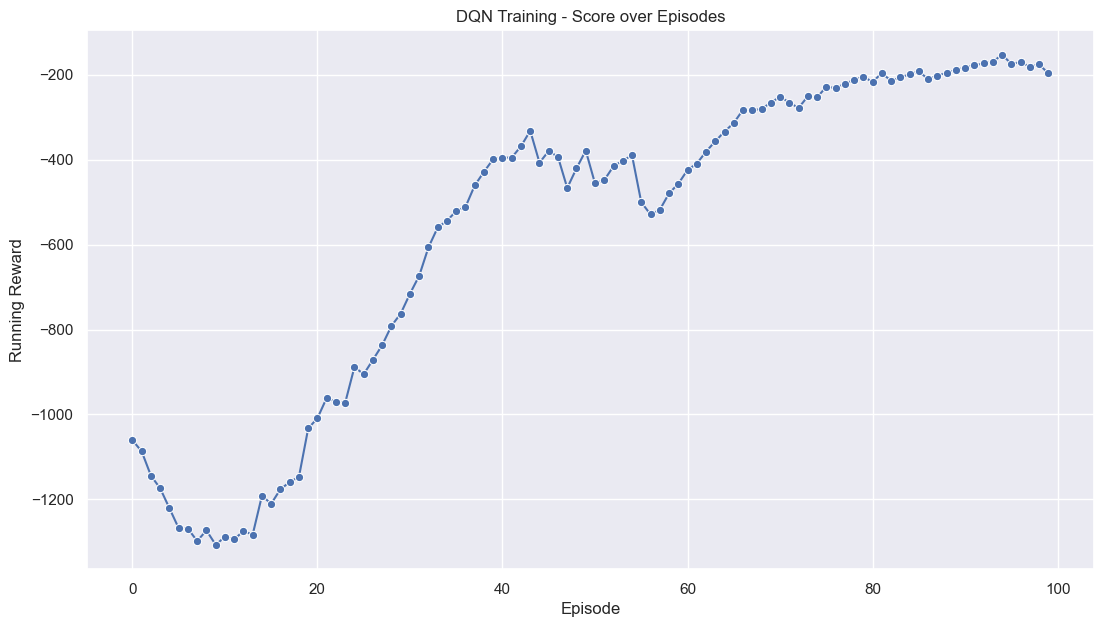

In [12]:
# Hyperparameters for DQN algorithm
class Args:
    gamma = 0.9 # discount factor
    num_actions = 5
    seed = 0
    render = False
    log_interval = 10

args = Args()

torch.manual_seed(args.seed)
np.random.seed(args.seed)

# Store the training records (episode number and reward)
TrainingRecord = namedtuple('TrainingRecord', ['ep', 'reward'])
# Store the transitions -> state (s), action (a), reward (r). next state (s_)
Transition = namedtuple('Transition', ['s', 'a', 'r', 's_'])

# Defines the neural network used by the DQN agent. Dense model with a linear activation function
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(3, 100)
        self.a_head = nn.Linear(100, args.num_actions)
        self.v_head = nn.Linear(100, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc(x), negative_slope=0.01)  # Using LeakyReLU
        a = self.a_head(x) - self.a_head(x).mean(1, keepdim=True)
        v = self.v_head(x)
        action_scores = a + v
        return action_scores




'''
This class stores experience transoitions encountered by the agent during training. This mechanism
is a core component of experience replay technique used in DQN networks to stablize and improve the learning process.
'''
class Memory():
    data_pointer = 0 # keeps track of current index in the memory buffer where the next transition will be stored.
    isfull = False # flag indicating whether memory buffer has been filled up at least once. Important to know whether memory buffer contains enough samples to start sampling or not

    # initialize the memory buffer
    def __init__(self, capacity):
        self.memory = np.empty(capacity, dtype=object)
        self.capacity = capacity

    # method to add a new transition to the memory buffer
    def update(self, transition):
        # new transition is stored in the memory at the data pointer index, which was initialized above, starting from 0
        self.memory[self.data_pointer] = transition
        # increment the data pointer to next location in memory for the next transition
        self.data_pointer += 1
        # if the buffer is filled, the flag will indicate TRUE and the future updates will start overwriting the old transitions, as pointer will reset to 0
        if self.data_pointer == self.capacity:
            self.data_pointer = 0
            self.isfull = True

    # this method randomly samples a batch of transitions from the memory, and batch_size determines the size of the batch.
    def sample(self, batch_size):
        return np.random.choice(self.memory, batch_size)

'''
This Agent class performs the behaviour and learning algorithm of the DQN model (agent). This class has the methods
for action selection, memory storage, parameter saving, and the learning algorithm of the dueling DQN network. It initializes
the 2 neural networks (eval_net and target_net) for calculating the Q-values, and an optimizer for training the eval_net.
'''
class Agent():

    '''
    This action_list generates a list of actions the agent can take. Since a DQN model is meant for discrete action spaces, but the Pendulum-v0 is 
    a continuous action space, we will need to convert the action space to discrete. We can do that by pre-defining the actions the model can take, such 
    as an increment of values from -2 to 2. This allows the model to choose a specific number. 
    '''
    action_list = [(i * 4 - 2,) for i in range(args.num_actions)]
    max_grad_norm = 0.5

    def __init__(self):
        self.training_step = 0
        # initial exploration rate is 1, which decays over time to encourage exploration at the start and exploitation of the learned policy later.
        self.epsilon = 1
        # the models
        self.eval_net, self.target_net = Net().float(), Net().float()
        # memory
        self.memory = Memory(2000)
        # optimizer
        self.optimizer = optim.Adam(self.eval_net.parameters(), lr=1e-3, weight_decay=1e-5)  # Added weight_decay for L2 regularization
        # Initialize temperature for Boltzmann exploration
        self.temperature = 1.0  



    '''
    Boltzmann exploration method for action selection. Q-values computed are transformed into a probability distribution
    using a softmax function. The temperature parameter controls the stochasticity of the action selection process. 
    When the temperature is high, the action probabilities become more uniform, increasing exploration.
    When the temperature is low, the action probabilities become more skewed towards the action with the highest Q-value, increasing exploitation.
    '''
    def select_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        q_values = self.eval_net(state).detach()  # Get Q-values for all actions
        probabilities = F.softmax(q_values / self.temperature, dim=-1).numpy()  # Apply softmax to convert Q-values to probabilities
        action_index = np.random.choice(np.arange(args.num_actions), p=probabilities.ravel())  # Choose action based on probabilities
        return self.action_list[action_index], action_index


    # save parameters
    def save_param(self):
        if not os.path.exists('param'):
            os.makedirs('param')
        torch.save(self.eval_net.state_dict(), 'param/dqn_improved_params.pkl')

    # store transition in the memory buffer. Contains the s, a, r ,s_ for the model to learn
    def store_transition(self, transition):
        self.memory.update(transition)

    '''
    This update method performs a single update step on the eval_net model, using a random batch of transitions from the memory. This
    method will 
    1. Sample a batch and convert them to pytorch tensors
    2. Use a double dqn method to decouple selection and evaluation of actions, 
    which will help reduce overestimations of Q-values regularly seen in natural DQNs
    3. Calculate the loss between predicted and target Q-values, and we use a smoothing L1 regularization
    technique as the loss objective function
    4. Perform backpropagation and optimization to update weights of eval_net
    5. Update target_net every 200 steps
    6. Decay exploration rate (epsilon) to slowly shift from exploration to exploitation
    '''
    def update(self):
        self.training_step += 1
        
        # take a batch from memory
        transitions = self.memory.sample(32)
        s = torch.tensor([t.s for t in transitions], dtype=torch.float)
        a = torch.tensor([t.a for t in transitions], dtype=torch.long).view(-1, 1)
        r = torch.tensor([t.r for t in transitions], dtype=torch.float).view(-1, 1)
        s_ = torch.tensor([t.s_ for t in transitions], dtype=torch.float)

        # natural dqn
        # q_eval = self.eval_net(s).gather(1, a)
        # with torch.no_grad():
        #     q_target = r + args.gamma * self.target_net(s_).max(1, keepdim=True)[0]

        # double dqn method, to reduce overestimations of Q-values
        with torch.no_grad():
            a_ = self.eval_net(s_).max(1, keepdim=True)[1]
            q_target = r + args.gamma * self.target_net(s_).gather(1, a_)
        q_eval = self.eval_net(s).gather(1, a)

        # optimizer 
        self.optimizer.zero_grad()
        # loss smoothing using l1 regularization, and calculating the loss between predicted and target q-values
        loss = F.smooth_l1_loss(q_eval, q_target)
        loss.backward()
        nn.utils.clip_grad_norm_(self.eval_net.parameters(), self.max_grad_norm)
        self.optimizer.step()

        # update the target_net every 200 steps to synchronise model with eval_net
        if self.training_step % 200 == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())

        # epsilon decay rate to move from exploration to exploitation
        self.epsilon = max(self.epsilon * 0.999, 0.01)

        self.temperature = max(self.temperature * 0.995, 0.01)  # Decrease temperature each episode or step

        return q_eval.mean().item()

# Main function to call all our above functions for the model to run
def main():
    env = gym.make('Pendulum-v0')
    env.seed(args.seed)

    agent = Agent()

    episodes, rewards = [], []  # Initialize empty lists to store episodes and rewards
    running_reward, running_q = -1000, 0
    for i_ep in range(100):
        score = 0
        state = env.reset()

        for t in range(200):
            action, action_index = agent.select_action(state)
            state_, reward, done, _ = env.step(action)
            score += reward
            if args.render:
                env.render()
            agent.store_transition(Transition(state, action_index, (reward + 8) / 8, state_))
            state = state_
            if agent.memory.isfull:
                q = agent.update()
                running_q = 0.99 * running_q + 0.01 * q

        running_reward = running_reward * 0.9 + score * 0.1

        episodes.append(i_ep)
        rewards.append(running_reward)

        if i_ep % args.log_interval == 0:
            print('Ep {}\tAverage score: {:.2f}\tAverage Q: {:.2f}'.format(i_ep, running_reward, running_q))
        if running_reward > -10:
            print("Solved! Running reward is now {}!".format(running_reward))
            break

    env.close()

    agent.save_param()
    
    return episodes, rewards  # Return the collected episodes and rewards

# Ensure this line is at the end of the script to call main and collect data
episodes, rewards = main()



# Set the seaborn style for the plots
sns.set_theme(style="darkgrid")

# Create the plot
plt.figure(figsize=(13, 7))
sns.lineplot(x=episodes, y=rewards, marker='o', linestyle='-', color='b')

# Set the title and labels
plt.title('DQN Training - Score over Episodes')
plt.xlabel('Episode')
plt.ylabel('Running Reward')

# Show the plot
plt.show()



### Evaluation

From the model graph, we can see that the model does not really perform much better than the original model despite changing the regularization, activation function and policy. 

However, we can tell that the stability of the model improves slightly, as when the model reaches -200 for the reward value, the model stabalizes and the reward value does not spike down, which occurs on the original model.

### Dueling DQN (Tensorflow implementation)

Now, we will attempt to use the Tensorflow module to implement dueling DQN for the pendulum-v0 problem. In this code, we will be using tensorflow's gradient tape function. 

GradientTape is a mathematical tool for automatic differentiation (autodiff), which is the core functionality of TensorFlow.

It allows us to compute the gradient while training the network. The computed gradients are essential to do backpropagation to correct the errors of the neural network to make it gradualy improve.

In [20]:
from tensorflow.keras import layers

# Setting seeds for reproducibility
SEED = 0
tf.random.set_seed(SEED)
np.random.seed(SEED)

''' 
Defines a neural network model inheriting from the tf.keras.Model. Contains a fully connected layer (fc) as the base, followed by 2 heads. 
a_head estimates the advantage of each action, while v_head estimates the state value
'''
class Net(tf.keras.Model):
    def __init__(self, num_actions):
        super(Net, self).__init__()
        # fully connected dense later
        self.fc = layers.Dense(100, activation='relu')
        # estimates advantage of each action
        self.a_head = layers.Dense(num_actions)
        # estimates state value
        self.v_head = layers.Dense(1)
    
    '''
    Forward pass, combines the action and state values to compute the Q-values for each action.
    Then, normalise by subtracting the mean average
    '''
    def call(self, x):
        # forward pass
        x = self.fc(x)
        # subtract mean average 
        a = self.a_head(x) - tf.reduce_mean(self.a_head(x), axis=1, keepdims=True)
        # get state value
        v = self.v_head(x)
        return a + v

'''
This class implements a simple experience replay buffer using a deque with the specified maximum length (capacity). This mechanism
is a core component of experience replay technique used in DQN networks to stablize and improve the learning process. Experience replay 
is a technique used to store the agent's experiences at each time step, e.g., state, action, reward, and next state, during training. 
These stored experiences, or "transitions," can later be sampled randomly to train the neural network model.
'''
class Memory:
    def __init__(self, capacity):
        # creates a double-ended queue with max length of 'capacity'. The deque is used to store transitions. When deque reaches maximum length, old transitions will be removed from the opposite end
        self.memory = deque(maxlen=capacity)
    
    def update(self, transition):
        # adds transition to the deque.
        self.memory.append(transition)
    
    def sample(self, batch_size):
        # uses random sample to randomly sample a batch of transitions from the memory
        return random.sample(self.memory, batch_size)

'''
This Agent class performs the behaviour and learning algorithm of the DQN model (agent). This class has the methods
for action selection, memory storage, parameter saving, and the learning algorithm of the dueling DQN network. It initializes
the 2 neural networks (eval_net and target_net) for calculating the Q-values, and an optimizer for training the eval_net.
'''
class Agent:
    def __init__(self, state_size, num_actions):
        self.state_size = state_size  
        self.num_actions = num_actions
        self.epsilon = 1.0 # epsilon-greedy policy, start off with pure exploration
        self.epsilon_min = 0.01 # epsilon minimum
        self.epsilon_decay = 0.995 # epsilon decay over time
        self.gamma = 0.9 # discount factor for future rewards, to emphasize the importance of immediate rewards vs future rewards
        self.memory = Memory(2000) 
        self.model = Net(num_actions)
        self.model.build((None, state_size))  # Build the model
        self.optimizer = tf.optimizers.Adam(1e-3)
        self.loss_fn = tf.losses.MeanSquaredError()
        self.best_total_reward = float('-inf')  # Initialize best total reward

    '''
    The select action method, uses the epsilon-greedy polict for action selection. With the probability of epsilon (e), it
    selects a random action (exploration), and when the probability 1 - epsilon, it selects the action with the highest Q-value as predicted by the eval_net (exploitation).
    '''
    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions), None
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        q_values = self.model(state)
        return np.argmax(q_values.numpy()), None

    '''
    Performs single update step on the model based on a batch of transitions sampled from memory.
    Extracts s, a, r, s_ from the transitions
    Uses the model to compute current Q-values for each state-action pair, and max Q-value for next states.
    Calculates the target Q-values (target_q) as the sum of the immediate reward and the discounted maximum future Q-value.
    '''
    def learn(self, batch_size):
        if len(self.memory.memory) < batch_size:
            return
        
        # take transitions from memory
        transitions = self.memory.sample(batch_size)
        # gets the s, a, r, s_ from transitions
        state_batch, action_batch, reward_batch, next_state_batch = zip(*transitions)
        
        # convert the s, a, r, s_ to tensors
        state_batch = tf.convert_to_tensor(state_batch, dtype=tf.float32)
        action_batch = tf.convert_to_tensor(action_batch, dtype=tf.int32)
        reward_batch = tf.convert_to_tensor(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(next_state_batch, dtype=tf.float32)
        
        '''
        We will use gradient tape imported from the tensorflow library.
        GradientTape is a mathematical tool for automatic differentiation (autodiff), which is the core functionality of TensorFlow.
        It allows us to compute the gradient while training the network. The computed gradients are essential to do backpropagation to 
        correct the errors of the neural network to make it gradualy improve.
        '''
        with tf.GradientTape() as tape:
            # Compute Q(s, a)
            q_values = self.model(state_batch)
            
            # selecting q-values for taken actions. It filters out the Q-values corresponding to the actions actually taken in each state.
            action_indices = tf.expand_dims(tf.range(batch_size), axis=1)
            action_indices = tf.concat([action_indices, tf.expand_dims(action_batch, axis=1)], axis=1)
            predicted_q = tf.gather_nd(q_values, action_indices)
            
            # Compute Q(s', a') for next states
            next_q_values = self.model(next_state_batch)
            max_next_q = tf.reduce_max(next_q_values, axis=1)
            
            # Compute target Q-values
            target_q = reward_batch + self.gamma * max_next_q
            
            # Compute loss
            # The loss is computed as the mean-squared error between predicted and target q-values
            # Gradients of the loss of the model's trainable variables are computed and applied to the model.
            loss = self.loss_fn(target_q, predicted_q)
        
        # applying gradients 
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        
        # Epsilon decay
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

    # adds new transition to memory for later sampling again
    def store_transition(self, transition):
        self.memory.update(transition)

    # checks if current model is the best model based on total reward
    def is_best_model(self, total_reward):
        return total_reward > self.best_total_reward

    # updates the best model with the current model
    def update_best_model(self, total_reward):
        self.best_total_reward = total_reward

# save the weights of the best model. if a better model is found, the weights will be overwritten
def save_model_weights(agent, model_dir):
    # Create the directory if it doesn't exist
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    # Save the weights of the best model
    weights_path = os.path.join(model_dir, 'tensorflow_dueling_dqn_weights.h5')
    agent.model.save_weights(weights_path)

# main function of the program to run the dueling DQN code
def main():
    env = gym.make('Pendulum-v0')
    env.seed(SEED)
    num_actions = 5
    state_size = env.observation_space.shape[0]
    agent = Agent(state_size, num_actions)

    episodes = 50
    for ep in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            action_index, _ = agent.select_action(state)
            action = [action_index * 4.0 / (num_actions - 1) - 2.0]  # Scale action
            next_state, reward, done, _ = env.step(action)
            agent.store_transition((state, action_index, reward, next_state))
            state = next_state
            total_reward += reward
            
            agent.learn(32)
        
        print(f"Episode: {ep+1}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")

        if agent.is_best_model(total_reward):
            # Update and save the best model weights
            agent.update_best_model(total_reward)
            model_dir = 'param'
            save_model_weights(agent, model_dir)
            print("Best model weights saved.")

if __name__ == '__main__':
    main()


Episode: 1, Total Reward: -1544.45, Epsilon: 0.43
Best model weights saved.
Episode: 2, Total Reward: -1227.09, Epsilon: 0.16
Best model weights saved.
Episode: 3, Total Reward: -1498.65, Epsilon: 0.06
Episode: 4, Total Reward: -526.65, Epsilon: 0.02
Best model weights saved.
Episode: 5, Total Reward: -1385.98, Epsilon: 0.01
Episode: 6, Total Reward: -1422.70, Epsilon: 0.01
Episode: 7, Total Reward: -763.78, Epsilon: 0.01
Episode: 8, Total Reward: -1499.98, Epsilon: 0.01
Episode: 9, Total Reward: -14.03, Epsilon: 0.01
Best model weights saved.
Episode: 10, Total Reward: -1411.11, Epsilon: 0.01
Episode: 11, Total Reward: -1245.09, Epsilon: 0.01
Episode: 12, Total Reward: -11.63, Epsilon: 0.01
Best model weights saved.
Episode: 13, Total Reward: -1431.96, Epsilon: 0.01
Episode: 14, Total Reward: -1131.07, Epsilon: 0.01
Episode: 15, Total Reward: -8.73, Epsilon: 0.01
Best model weights saved.
Episode: 16, Total Reward: -1089.97, Epsilon: 0.01
Episode: 17, Total Reward: -8.78, Epsilon: 0.0

### View the movement of the pendulum using the best model

In [29]:
# Create a class for loading and visualizing the model
class TrainedModelVisualizer:
    def __init__(self, model_dir, num_actions):
        self.model_dir = model_dir
        self.num_actions = num_actions
        self.state_size = None
        self.model = None

    def load_model(self):
        # Initialize the environment to get state size
        env = gym.make('Pendulum-v0')
        self.state_size = env.observation_space.shape[0]

        # Create a new model with the same architecture
        self.model = Net(self.num_actions)
        self.model.build((None, self.state_size))
        
        # Load the model weights
        weights_path = os.path.join(self.model_dir, 'tensorflow_dueling_dqn_weights.h5')
        self.model.load_weights(weights_path)

    def visualize(self):
        if self.model is None:
            print("Model not loaded. Call load_model() first.")
            return

        env = gym.make('Pendulum-v0')
        state = env.reset()
        done = False

        while not done:
            env.render()
            action_index, _ = self.select_action(state)
            action = [action_index * 4.0 / (self.num_actions - 1) - 2.0]  # Scale action
            next_state, _, done, _ = env.step(action)
            state = next_state

        env.close()

    def select_action(self, state):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        q_values = self.model(state)
        return np.argmax(q_values.numpy()), None

# Define the same neural network architecture
class Net(tf.keras.Model):
    def __init__(self, num_actions):
        super(Net, self).__init__()
        self.fc = tf.keras.layers.Dense(100, activation='relu')
        self.a_head = tf.keras.layers.Dense(num_actions)
        self.v_head = tf.keras.layers.Dense(1)
    
    def call(self, x):
        x = self.fc(x)
        a = self.a_head(x) - tf.reduce_mean(self.a_head(x), axis=1, keepdims=True)
        v = self.v_head(x)
        return a + v

# Directory where the trained model weights are saved
model_dir = 'param'

# Number of actions (same as in the training script)
num_actions = 5

# Create the visualizer and load the model
visualizer = TrainedModelVisualizer(model_dir, num_actions)
visualizer.load_model()

# Visualize the Pendulum environment using the loaded model
visualizer.visualize()


## DDPG Agent

The Deep Deterministic Policy Gradient (DDPG) agent is an off policy algorithm and can be thought of as DQN for continuous action spaces, which is what the pendulum environment has. It learns a policy (the actor) and a Q-function (the critic). The policy is deterministic and its parameters are updated based on applying the chain rule to the Q-function learnt (expected reward). The Q-function is updated based on the Bellman equation, as in Q learning.

Here is the formula:

$$
a^*(s) = \arg \max_a Q^*(s,a).
$$



The actor-critic framework uses the approach where 
    - The actor learns a policy (mapping a state to actions)
    - The critic evaluates the actions taken by the actor

How is DDPG meant specifically for environments with continuous action spaces?
It relates to how the $max_a Q^*(s,a)$ formula is computed. When there are a finite number of discrete actions, the max poses no problem, because we can just compute the Q-values for each action separately and directly compare them. (This also immediately gives us the action which maximizes the Q-value.) But when the action space is continuous, we can’t exhaustively evaluate the space, and solving the optimization problem is highly non-trivial. Using a normal optimization algorithm would make calculating $max_a Q^*(s,a)$ a painfully expensive subroutine. And since it would need to be run every time the agent wants to take an action in the environment, this is unacceptable.


References:
[Deep Determinalistic Policy Gradient](https://spinningup.openai.com/en/latest/algorithms/ddpg.html#id1)

### DDPG model (Pytorch implementation)

In [26]:
import argparse
import pickle
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np

import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import os

class Args:
    gamma = 0.9
    seed = 0
    render = False
    log_interval = 10

args = Args()

torch.manual_seed(args.seed)
np.random.seed(args.seed)

TrainingRecord = namedtuple('TrainingRecord', ['ep', 'reward'])
Transition = namedtuple('Transition', ['s', 'a', 'r', 's_'])

'''
ActorNet represents the actor network, which takes a state as inputs and outputs of an action. The network has two fully connected layers, followed 
by a tanh activation to constrain actions within a specific range. It learns a deterministic policy that maps states to specific actions, rather 
than a probability distribution over actions.
'''
class ActorNet(nn.Module):

    def __init__(self):
        super(ActorNet, self).__init__() # initialize common attributes and methods
        self.fc = nn.Linear(3, 100) # creates a fully connected layer with 3 input neurons (matching the state dimension) and 100 output neurons.
        self.mu_head = nn.Linear(100, 1) # another fully connected layer with 100 input neurons and 1 output neuron.

    '''
    Forward pass, which takes a state as input and outputs an action. The action is constrained within the range of [-2, 2] using a tanh activation function.
    '''
    def forward(self, s):
        x = F.relu(self.fc(s)) # apply first fully connected layer and ReLU activation for non-linearity
        u = 2.0 * F.tanh(self.mu_head(x)) # Applies the second fully connected layer, a tanh activation function to constrain the output between -1 and 1, and scales the output by 2.0 for pendulum problem action range
        return u 

'''
CriticNet represents the critic neural network, which takes both state and action as input and outputs a state-action value. The network also has 2 fully
connected layers. It uses ReLU activation for non-linearity, and helps the agent learn to evaluate the quality of its actions in different states
'''
class CriticNet(nn.Module):
    
    # Constructor 
    def __init__(self):
        super(CriticNet, self).__init__() # initialize common attributes and methods
        self.fc = nn.Linear(4, 100) # creates a fully connected layer with 4 input neurons (matching the state dimension + action dimension) and 100 output neurons.
        self.v_head = nn.Linear(100, 1) # another fully connected layer with 100 input neurons and 1 output neuron.

    '''
    Forward pass, which takes a state-action pair as input and outputs a state-action value. It defines how input data should flow through the network to compute the Q-value.
    '''
    def forward(self, s, a):
        x = F.relu(self.fc(torch.cat([s, a], dim=1))) # concatenates the state and action along a single dimension, basically combining them into a single tensor, and then applies the fully connected layer to tne tensor, along with the relu activation function
        state_value = self.v_head(x) # pass the output of the previous layer to the second fully connected layer, which outputs the state-action value
        return state_value # return the state-action value as the forward pass output

'''
This class stores experience transoitions encountered by the agent during training. This mechanism
is a core component of experience replay technique used in DQN networks to stablize and improve the learning process.
'''
class Memory():

    '''
    Pointers used to keep track of positions in the memory buffer. Data-pointer keeps track of the current index in the memory buffer where the next transition will be stored.
    Will be incremented each time a new transition is added to the buffer. When it reaches the maximum capacity, it will be reset to 0 and start overwriting the old transitions.
    '''
    data_pointer = 0
    isfull = False

    def __init__(self, capacity):
        self.memory = np.empty(capacity, dtype=object)
        self.capacity = capacity

    # adds a new transition to the memory buffer, a transition is a tuple of (state, action, reward, next state)
    def update(self, transition):
        self.memory[self.data_pointer] = transition
        self.data_pointer += 1
        if self.data_pointer == self.capacity:
            self.data_pointer = 0
            self.isfull = True

    # samples a random batch of transitions from the memory
    def sample(self, batch_size):
        return np.random.choice(self.memory, batch_size)


'''
Implements the DDPG algorithm. 
'''
class Agent():

    # sets the maximum gradient norm value for gradient clipping during optimization.
    max_grad_norm = 0.5

    # initializes the agent
    def __init__(self):
        self.training_step = 0
        self.var = 1.
        
        '''
        Two critic networks (value networks) represented by instances of the CriticNet class. The agent maintains both an 
        evaluation critic network (eval_cnet) and a target critic network (target_cnet). These networks are used in DDPG for estimating state-action values.
        '''
        self.eval_cnet, self.target_cnet = CriticNet().float(), CriticNet().float() 
        
        '''
        Two actor networks represented by instances of the ActorNet class. Similar to the critic networks, the agent maintains both an evaluation 
        actor network (eval_anet) and a target actor network (target_anet). These networks are used for selecting actions in the environment.
        '''
        self.eval_anet, self.target_anet = ActorNet().float(), ActorNet().float()
        self.memory = Memory(2000)
        self.optimizer_c = optim.Adam(self.eval_cnet.parameters(), lr=1e-3)
        self.optimizer_a = optim.Adam(self.eval_anet.parameters(), lr=3e-4)


    '''
    This method takes a state as input and returns an action selected by the agent's evaluation actor network (eval_anet). The method performs the following steps:
    - Converts the state to a PyTorch tensor.
    - Passes the state through the evaluation actor network to obtain the mean (mu) of the action distribution.
    - Adds exploration noise to the action by sampling from a normal distribution with mean mu and standard deviation self.var.
    - Clamps the action values to ensure they fall within the range of [-2.0, 2.0].
    - Returns the selected action as a tuple with a single value.
    '''
    def select_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        mu = self.eval_anet(state)
        dist = Normal(mu, torch.tensor(self.var, dtype=torch.float))
        action = dist.sample()
        action.clamp(-2.0, 2.0)
        return (action.item(),)

    # save parameters of both the evaluation actor and critic networks
    def save_param(self):
        if not os.path.exists('param'):
            os.makedirs('param')
        torch.save(self.eval_anet.state_dict(), 'param/ddpg_anet_params.pkl')
        torch.save(self.eval_cnet.state_dict(), 'param/ddpg_cnet_params.pkl')

    # store transitions in the memory buffer. Calls the update method to add transition to internal memory buffer
    def store_transition(self, transition):
        self.memory.update(transition)

    '''
    Update method is called to perform training update on the agnet. It performs the following steps:
    - Samples a batch of transitions from the memory buffer.
    - Calculates the target Q-values using the target critic network (target_cnet).
    - Calculate the Q-values using the evaluation critic network (eval_cnet).
    - Compute the loss between the predicted and target Q-values. (q_eval and q_target)
    - Update the critic network's parameters using gradient descent and gradient clipping
    - Compute the actor loss (a_loss) as the negative mean of eval_cnet(s, eval_anet(s)). 
    This loss encourages the actor to select actions that maximize the expected future rewards as estimated by the critic.
    - Update the actor's network parameters 
    - Periodically update the target networks by copying the parameters from the evaluation networks.
    
    '''
    def update(self):
        self.training_step += 1

        transitions = self.memory.sample(32)
        s = torch.tensor([t.s for t in transitions], dtype=torch.float)
        a = torch.tensor([t.a for t in transitions], dtype=torch.float).view(-1, 1)
        r = torch.tensor([t.r for t in transitions], dtype=torch.float).view(-1, 1)
        s_ = torch.tensor([t.s_ for t in transitions], dtype=torch.float)

        with torch.no_grad():
            q_target = r + args.gamma * self.target_cnet(s_, self.target_anet(s_))
        q_eval = self.eval_cnet(s, a)

        # update critic net
        self.optimizer_c.zero_grad()
        c_loss = F.smooth_l1_loss(q_eval, q_target)
        c_loss.backward()
        nn.utils.clip_grad_norm_(self.eval_cnet.parameters(), self.max_grad_norm)
        self.optimizer_c.step()

        # update actor net
        self.optimizer_a.zero_grad()
        a_loss = -self.eval_cnet(s, self.eval_anet(s)).mean()
        a_loss.backward()
        nn.utils.clip_grad_norm_(self.eval_anet.parameters(), self.max_grad_norm)
        self.optimizer_a.step()

        if self.training_step % 200 == 0:
            self.target_cnet.load_state_dict(self.eval_cnet.state_dict())
        if self.training_step % 201 == 0:
            self.target_anet.load_state_dict(self.eval_anet.state_dict())

        self.var = max(self.var * 0.999, 0.01)

        return q_eval.mean().item()

# Main function to run everything
def main():
    env = gym.make('Pendulum-v0')
    env.seed(args.seed)

    agent = Agent()

    training_records = []
    running_reward, running_q = -1000, 0
    for i_ep in range(100):
        score = 0
        state = env.reset()

        for t in range(200):
            action = agent.select_action(state)
            state_, reward, done, _ = env.step(action)
            score += reward
            if args.render:
                env.render()
            agent.store_transition(Transition(state, action, (reward + 8) / 8, state_))
            state = state_
            if agent.memory.isfull:
                q = agent.update()
                running_q = 0.99 * running_q + 0.01 * q

        running_reward = running_reward * 0.9 + score * 0.1
        training_records.append(TrainingRecord(i_ep, running_reward))

        if i_ep % args.log_interval == 0:
            print('Step {}\tAverage score: {:.2f}\tAverage Q: {:.2f}'.format(
                i_ep, running_reward, running_q))
        if running_reward > -10:
            print("Solved! Running reward is now {}!".format(running_reward))
            env.close()
            agent.save_param()
            with open('param/ddpg_training_records.pkl', 'wb') as f:
                pickle.dump(training_records, f)
            break

    env.close()

if __name__ == '__main__':
    main()

Step 0	Average score: -1023.92	Average Q: 0.00
Step 10	Average score: -1220.47	Average Q: -0.82
Step 20	Average score: -1276.70	Average Q: 1.26
Step 30	Average score: -1152.56	Average Q: 2.92
Step 40	Average score: -838.46	Average Q: 5.73
Step 50	Average score: -584.43	Average Q: 7.15
Step 60	Average score: -652.68	Average Q: 6.03
Step 70	Average score: -493.84	Average Q: 7.24
Step 80	Average score: -369.60	Average Q: 8.61
Step 90	Average score: -383.67	Average Q: 7.66
Step 100	Average score: -318.57	Average Q: 8.56
Step 110	Average score: -302.35	Average Q: 8.48
Step 120	Average score: -375.43	Average Q: 7.63
Step 130	Average score: -330.48	Average Q: 8.24
Step 140	Average score: -298.65	Average Q: 8.63
Step 150	Average score: -389.77	Average Q: 7.86
Step 160	Average score: -313.77	Average Q: 8.56
Step 170	Average score: -349.76	Average Q: 8.01
Step 180	Average score: -334.63	Average Q: 8.44
Step 190	Average score: -213.90	Average Q: 9.17
Step 200	Average score: -364.48	Average Q: 7.8

KeyboardInterrupt: 

### Testing the DDPG model (Pytorch)

In [ ]:
actor_model = ActorNet()
critic_model = CriticNet()

actor_model.load_state_dict(torch.load('param\ddpg_anet_params.pkl'))
critic_model.load_state_dict(torch.load('param\ddpg_cnet_params.pkl'))

actor_model.eval()
critic_model.eval()
def test_ddpg(env_name='Pendulum-v0', num_episodes=10, render=True):
    env = gym.make(env_name)
    env.seed(0)  # Optional: for reproducibility
    
    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        
        while not done:
            state = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                action = actor_model(state).cpu().data.numpy().flatten()
            
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            
            if render:
                env.render()
            
            state = next_state
        
        print(f"Episode: {episode + 1}, Reward: {episode_reward}")

    env.close()

# Call the test function
test_ddpg(num_episodes=2, render=True)

Episode: 1, Reward: -364.1259100057989
Episode: 2, Reward: -132.74331920938988


: 